# Setup

In [ ]:
!pip install transformers datasets
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!gdown --id 1Flw7JbavAh65vZrsjitW2ca-AZEKI3bN
!gdown  --id 1y1UeamHmgxkgD1gVtDqCWQ6t7D6MEE4M
!unzip  goldenspear_model.zip

In [2]:
%%capture
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')  

dataset_url = 'https://app.goldenspear.com/ratings.csv'
data = pd.read_csv(dataset_url)
len_original = len(data)

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

colors = sns.color_palette('pastel')
sns.set(rc={'figure.figsize':(10,5)}, font_scale=1.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})
# sns.color_palette('Set2')

In [3]:
from transformers import (
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    EvalPrediction
)
from datasets import load_metric

def compute_metrics(p: EvalPrediction):
  """
  Calcula las metricas de la lista metrics.
  Cada predicción de los modelos [MODEL_NAME]ForSequenceClassification es un 
  array de dimensiones == n_labels. Para compararlo con los labels se clasifica
  cada ejemplo en base a la clase mas probable 
  """
  acc = load_metric("accuracy")
  preds = np.argmax(p.predictions, axis=1)
  return acc.compute(predictions=preds, references=p.label_ids)

tokenizer = AutoTokenizer.from_pretrained("best_model")

In [4]:
import random
from collections import defaultdict
from statistics import mean,median
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    if isinstance(dataset,pd.core.frame.DataFrame):
      df = dataset.iloc[picks]
    else:
      df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))


# Problem statement


We are given a dataset that contains product reviews and a rating for
each product. A product can be rated from one to five. Clearly, the review is highly
correlated with the final score that the users give to the product. The dataset provided
contains 10K samples. We would like you to analyze the dataset and build a model
that is able to predict from a given review its score. For this purpose, the use of
open-source libraries is encouraged.
You can download the dataset from https://app.goldenspear.com/ratings.csv

1. Data analysis. Plot the balance of classes and show the five most predominant
words for each class.
2. Data cleaning. Have you performed data cleaning? If so, what kind of data
cleaning and which tools have you used?
3. Learning process. Answer briefly these questions:
a. What kind of features have you used?
b. What model or models have you chosen? Why?
c. What libraries have you used?
4. Models validation. Evaluate the performance of your estimator using some
validation methods and answer these questions:
a. What validation method have you chosen?
b. What evaluation metric have you chosen?
c. Write down your training and testing accuracies.
5. Final summary. Write down what would you have done if we had given you
more time and data.

This notebook is structured as follows:

* Below this you can find a quick summary with concise responses of the problem questions
* Section **Data Analysis & Cleaning** covers points 1 and 2.
* Section **Learning Process and Model Validation** covers point 3 and 4.
* Section **Final Summary** provides conclusions.

## Quick Summary & Responses


Top 5 words for reviews with 1 rating
----------------------------------------
52	small
47	same
44	much
42	other
39	good


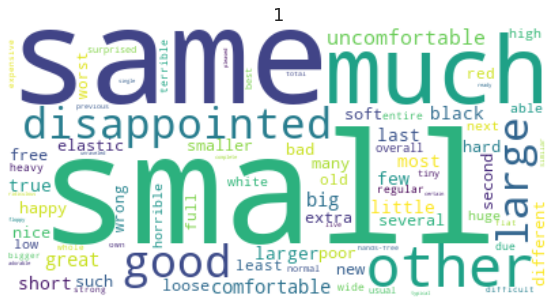




Top 5 words for reviews with 2 rating
----------------------------------------
73	much
62	same
59	other
56	small
55	comfortable


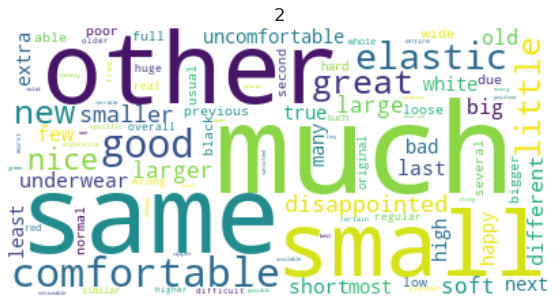




Top 5 words for reviews with 3 rating
----------------------------------------
87	little
75	good
73	comfortable
58	great
56	other


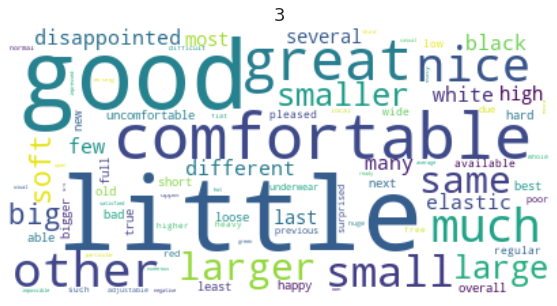




Top 5 words for reviews with 4 rating
----------------------------------------
162	great
152	little
130	good
129	comfortable
78	other


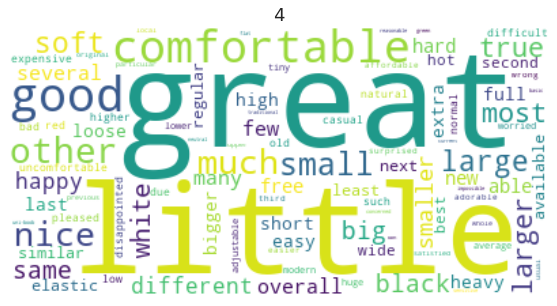




Top 5 words for reviews with 5 rating
----------------------------------------
148	great
75	comfortable
75	much
63	other
57	easy


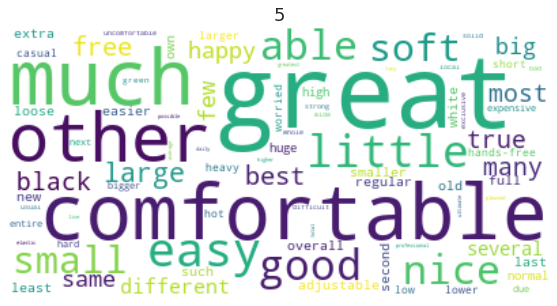

In [103]:
#@markdown ### **1.Data analysis. Plot the balance of classes and show the five most predominant words for each class.** 
#@markdown _____ 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white')

for rate in range(1,6):
  sorted_tokens = sorted(rating_tokens[rate].items(), key = lambda item: item[1], reverse=True)[:5]
  print(f"Top 5 words for reviews with {rate} rating\n{'-'*40}")
  for word,freq in sorted_tokens:
    print(freq,word,sep='\t')
  wordcloud.generate_from_frequencies(rating_tokens[rate])
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(rate)
  plt.show()
  print('\n'*2)


**2. Data cleaning. Have you performed data cleaning? If so, what kind of data cleaning and which tools have you used?**
_____

_Cleaning_
*   Deleated Duplicates
*  Fixed backslash scape problems
  * Replace unsacped linereaks with a space
  * Remove the incomplete sentence from the review
  * Remove backslash from the reviews

_Tools_
* numpy
* nltk
* matplotlib



**3. Learning process. Answer briefly these questions:**
___
  **a. What kind of features have you used?**

Plain text tokenized with a transformer. Deep learning systems benefit from the plain text statistics and no punctuation was removed as it contains informamtion of the review

**b. What model or models have you chosen? Why?**

A pretrained transformer encoder arquitecture as it  has been shown to yield the best results in downstream task when finetuned. After a hypermparameter sweep th best model was [RoBERTa base model](https://huggingface.co/roberta-base)

**c. What libraries have you used?**
* [ 🤗 Trasformers](https://github.com/huggingface/transformers/) for tokenizing, training and everithing related with utilizing the model
* [Hydra](https://hydra.cc/) for configuration and reproducibility to follow MLOps 
* [Weights & Biases](https://wandb.ai/) for logging, hyperparameter tunning and creating dashboards

In [104]:
#@markdown **4. Models validation. Evaluate the performance of your estimator using some
#@markdown validation methods and answer these questions:**
#@markdown ___
#@markdown **a. What validation method have you chosen?**
#@markdown 
#@markdown Hold-Out
#@markdown 
#@markdown **b. What evaluation metric have you chosen?**
#@markdown Accuracy. confusion matrix for better visualization.
#@markdown 
#@markdown **c. Write down your training and testing accuracies.**
display(HTML(df.to_html()))

,Split,Accuracy
0,train,0.824458
1,dev,0.587888
2,test,0.568047



**5. Final summary. Write down what would you have done if we had given you
more time and data.**


* Train better models with more data and more resources
* Explore other models
* Colect even more data and add new features from the reviwer.
* Extensive data cleaning and exploration
* Problem visualization
* Try different cleaning procedures 

# Data Analysis & Cleaning

Analyzing and cleaning text is an iterative process. In order to clean effectivly is important to first find and understand the problems the dataset have. On the other hand is important to analyse the text after is clean to understand the characteristics and statistics of the data thats is going to be used. 








In [5]:
data = data.drop_duplicates()
print(f"Number of examples: {len_original}\nNumber of duplicates: {len_original-len(data)}")

Number of examples: 10000
Number of duplicates: 6533


More than 65% of the examples where duplicates.

,TEXT,RATING,TEXT_LENGTH
2114,"I like the design on them, but once I put them on I realized the low quality of them. The rear is completely see-through once you put them on. It also looks very unflattering as it cuts weirdly into your skin instead of keeping everything tight and together like high-quality spandex pants do. They were fairly thin and not very stretchy, so I feared they'd rip immediately when doing any kind of workout. Wish I tried them on first; I will be returning.",2,83
3570,"These use to be my favorite panties but the past couple years when I've purchased them the fabric and sewing were horrible. Some of the crotches were very narrow, like only 1 1/2 to 2 inches wide. Barely would wear a feminine pad. Some had fabric that were really thin causing leg area to stretch and ride up. Some were like bikinis not boy shorts. Major flaw in production/inspection line! They also need to stitch the front & back crotch material onto panty. Feminine pads won't stay put. I've been just cutting them off and use a thin pad as liner.",2,101
2950,Did not like material. Very uncomfortable to wear. Returned for credit.,2,11
1792,"I have been buying this bra for years, same size, 34D.\nA recent order arrived, and although they are marked 34D,\nthe cup is about 2 sizes too small. I'm assuming some sort of\nmislabeling or defect, but they are not wearable. They will all\nbe going back. Too bad. It was a great buy.",1,51
2703,This is too short in the shoulders. I have a long torso and am long through the upper chest to my shoulders. Finding bras that don't pull down on my shoulders is always a challenge. This is definitely uncomfortable. I'm going to return it.,2,44
9918,"I specifically bought this product for my dance recital. It was pretty easy application and comfortable. However, once I started sweating it began to unstick a little. I will still use it, but maybe not for such sweaty activities. Btw, I am 16 and I am usually a A cup, sometimes B, but I went with the B and it fit well. Overall good product.",4,65
2393,"Material is a sticky polyester material and feels cheap. I am 5ft 10in and athletic and was looking not for a golf pant, but something I could wear to the gym and around town other than typical shorter yoga pants. For my height, the rise is way too short for me. Will return both pairs I bought to my local Target store.",2,62
3631,"I was in love with the older version of these and was so excited when I saw these in the stores again. Unfortunately after wearing this new version, I quickly became disappointed. When I first put them on, I noticed that they barely came up enough in the back to cover my rear. Also the length of the legs are not long enough and they seem to roll up. Please Please Please Hanes bring back the older version that we all loved so much!! They were such a good fit and were very comfortable to wear unlike this version.",2,99
9975,"This is the third similar bra that I have purchased. Fits well, washes well, many colors.",4,16
663,"These mittens were in the ladies department, however they are so narrow they are not sized correctly. I have very small hands",1,22


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


            RATING  TEXT_LENGTH
count  3467.000000  3467.000000
mean      3.035766    44.831843
std       1.385937    34.460624
min       1.000000     1.000000
25%       2.000000    20.000000
50%       3.000000    37.000000
75%       4.000000    60.000000
max       5.000000   397.000000


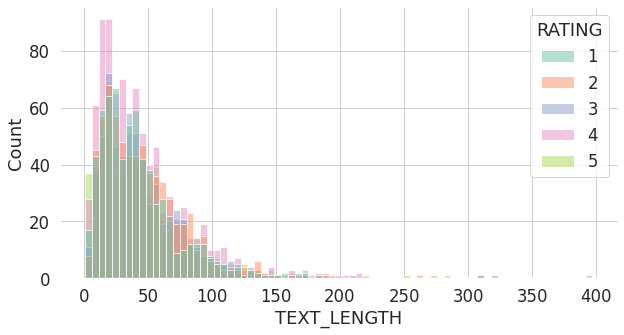

In [6]:
tokens = [text.split() for text in data['TEXT']]
data['TEXT_LENGTH'] = [len(text) for text in tokens]
sns.histplot(data,x='TEXT_LENGTH',hue='RATING',palette='Set2')
show_random_elements(data)
print(data.describe())

After iterating through the examples no mayor problem could be appreciated. However we can see both in the statistics of TEXT_LENGTH and in the plot that there are reviews with only one or two words. 

In [7]:
data.sort_values('TEXT_LENGTH').head(10) 

,TEXT,RATING,TEXT_LENGTH
3106,\,2,1
6185,I'm 5'5\,5,2
8126,I'm 5'3\,4,2
6254,I'm 5\,5,2
6186,I'm 5'7\,5,2
8093,I am 5'2\,4,3
6010,Perfect for casual,5,3
8728,I am 5'6\,4,3
4650,In the \,3,3
464,I am 5'5\,1,3


Printing the shortests reviews highlighted a problem in the dataset. The character \, commonly used to scape secuences, has not been processed correctly. 

In [8]:
set([word for text in tokens for word in text if '\\' in word])

{'!\\nI',
 "(5'2\\",
 "(5'3\\",
 "(5'4\\",
 "(5'6\\",
 "(5'8\\",
 "(5\\'4",
 '(L).\\nWhen',
 '*BRIEFS*\\nTHESE',
 '....\\n\\nI',
 '...\\nIt',
 '...\\n\\nI',
 '2010.\\n\\nThe',
 '22.75\\',
 '28.5\\',
 '2?\\nNot',
 '2\\',
 '30\\',
 '32\\',
 '34D,\\nthe',
 '34D.\\nA',
 '34\\',
 '36DD\\nand',
 '36\\',
 '39\\',
 '3\\',
 "4'11\\",
 '40dd\\nI',
 '41\\',
 '4\\',
 "5'0\\",
 "5'10\\",
 "5'1\\",
 "5'2\\",
 "5'3\\",
 "5'4\\",
 "5'5\\",
 "5'6\\",
 "5'7\\",
 "5'8\\",
 "5'9\\",
 '5.9\\',
 '5.\\nIf',
 '5\\',
 "5\\'2",
 "5\\'3",
 "5\\'4",
 "5\\'4&quot;",
 "5\\'5",
 '6\\',
 '7\\',
 '8\\',
 '9\\',
 '9\\\\10.\\nThese',
 ";)\\nI'd",
 'BEWARE***\\nWhen',
 'BUT-\\nwhen',
 'DD).\\n\\nOverall',
 'DOESN\\',
 'Hanes.\\nAlso',
 'ITEM.\\nTo',
 'I\\',
 "I\\'d",
 "I\\'m",
 "It\\'s",
 "Lol\\nI'm",
 'Loungewear!!\\n\\nThese',
 'NUDE.\\nThank',
 'ONE\\nsmall',
 'Plus:\\n-',
 'Pros:\\n-',
 "Sink-washable!)\\n\\nI've",
 "Wouldn\\'t",
 '\\',
 '\\/><br',
 '\\/>My',
 '\\nHowever',
 '\\nOVERALL:',
 '\\nPROBLEMS:',
 '\\nTerri

After further analysis there are three types of problems concerning the backslash character. 
* Some linebreaks have not been processed. 
  * Fix: Replace unsacped linereaks with a space 
* Other linebreaks have resulted in incompleted reviews (around 9%).
  * Fix: Remove the incomplete sentence from the review
* Other problems include unscaped apostrophes
  * Fix: Remove backslash from the reviews



In [9]:
backslash_text = []
incomplete_sentences = {}
for i,text in enumerate(data['TEXT']):
  text = text.replace('\\n', ' ') # Replace unscaped linebreaks with spaces
  if text.endswith('\\'): # If the sentence is not complete mark it as invalid
    incomplete_sentences[i] = text
    backslash_text.append('') 
  text = text.replace('\\', '') # Remove other unscaped backslash 
  backslash_text.append(text)

print(f"Percentage of incomplete reviews {len(incomplete_sentences)/len(data) * 100:.2f}%")

from nltk.tokenize import sent_tokenize

def clean_backslash(text: str):
  text = text.replace('\\n', ' ') # Replace unscaped linebreaks with spaces
  if text.endswith('\\'): # If the sentence is not complete mark it as invalid
    sentences = sent_tokenize(text)
    text = ''.join(sentences[:-1])
  text = text.replace('\\', '') # Remove other unscaped backslash 
  return text
data['TEXT'] = data['TEXT'].apply(clean_backslash)
data['TEXT_LENGTH'] = [len(text.split()) for text in data['TEXT']]

clean_data = data[data['TEXT_LENGTH']>1]

Percentage of incomplete reviews 9.14%


After cleaning we now can plot the class distribution in our dataset.

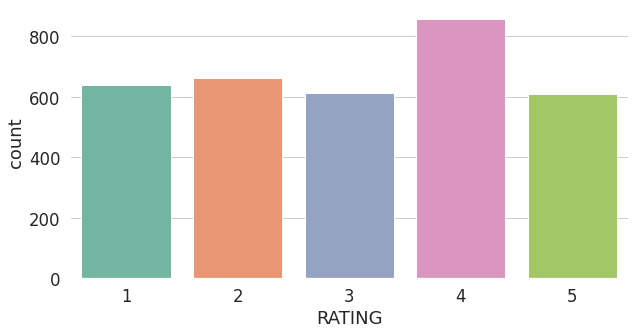

In [10]:
 sns.countplot(data=clean_data,x='RATING',palette='Set2')

In [20]:
rating_tokens = defaultdict(lambda: defaultdict(int))
tags = [ 'ADJ']

for _, row in clean_data.iterrows():
  rating = row['RATING']
  tokens = row['TEXT'].lower().split()
  for token in tokens:
    _, tag = nltk.pos_tag([token],tagset='universal')[0]
    if tag in tags: 
      rating_tokens[rating][token]+=1


Top 5 words for reviews with 1 rating
----------------------------------------
52	small
47	same
44	much
42	other
39	good


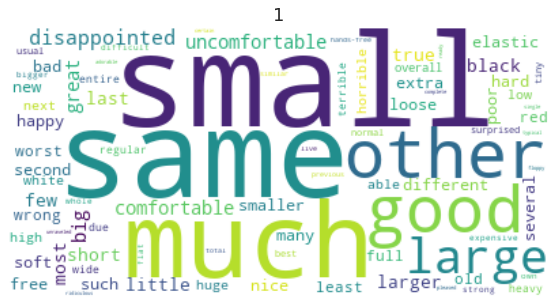




Top 5 words for reviews with 2 rating
----------------------------------------
73	much
62	same
59	other
56	small
55	comfortable


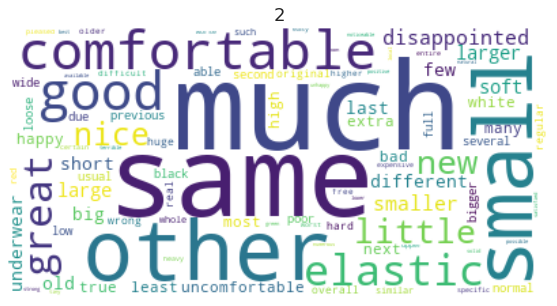




Top 5 words for reviews with 3 rating
----------------------------------------
87	little
75	good
73	comfortable
58	great
56	other


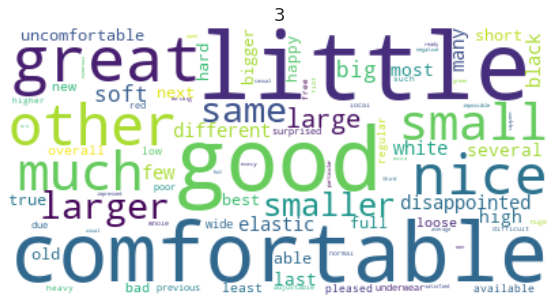




Top 5 words for reviews with 4 rating
----------------------------------------
162	great
152	little
130	good
129	comfortable
78	other


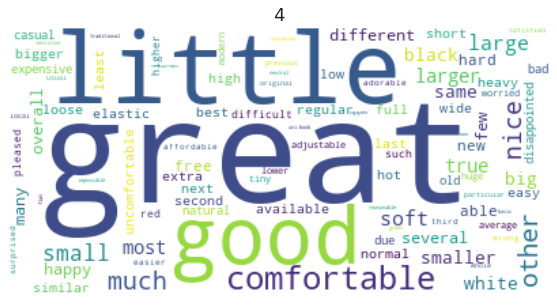




Top 5 words for reviews with 5 rating
----------------------------------------
148	great
75	comfortable
75	much
63	other
57	easy


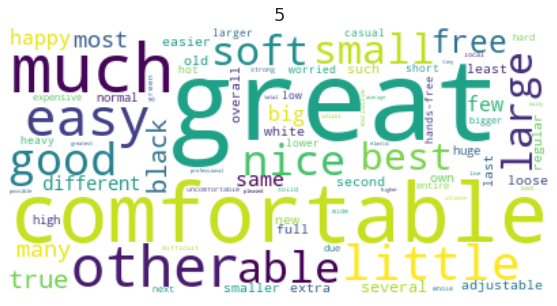

In [21]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white')

for rate in range(1,6):
  sorted_tokens = sorted(rating_tokens[rate].items(), key = lambda item: item[1], reverse=True)[:5]
  print(f"Top 5 words for reviews with {rate} rating\n{'-'*40}")
  for word,freq in sorted_tokens:
    print(freq,word,sep='\t')
  wordcloud.generate_from_frequencies(rating_tokens[rate])
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(rate)
  plt.show()
  print('\n'*2)

# Learning Process and Model Validation



## Create Train/Dev/Test Splits

Before we can train our model we need to decide how are we going to evaluate it. Given the time and resource restrictions of this problem a simple hold-out with 60/20/20 for training validation and testing respectively will do. Given enough time and resources a full crossvalidation would be a better option.

Splits preserve the class distribution.

In [22]:
from sklearn.model_selection import train_test_split
import datasets
text_train, text_dev_test, claim_train, claim_dev_test = train_test_split(clean_data['TEXT'], clean_data['RATING']-1, test_size=0.40, random_state=0)
text_test, text_dev, claim_test, claim_dev = train_test_split(text_dev_test, claim_dev_test, test_size=0.5, random_state=0)

train = datasets.Dataset.from_dict({
    'text':text_train,
    'labels':claim_train
})

dev = datasets.Dataset.from_dict({
    'text':text_dev,
    'labels':claim_dev
})

test = datasets.Dataset.from_dict({
    'text':text_test,
    'labels':claim_test
})

splits = datasets.DatasetDict({
    'train':train,
    'dev':dev,
    'test':test
})


## Validation


After the data is clean an analyzed we proced to choose model, training and validating it. The recent advances in transfer learning allow the use of very powerfull pretrained transformer models which have been used to a grate success in many NLP tasks. One major benefit of using Deep Learning models is that we don't have to manually select features for our model. Is traditional NLP pipelines punctuation might have needed to be removed, words may be filtered based on their POS and the input is usually transform in a frequency based vector representation. On the contrary deep learning systems exploit the natural representation of text.

The main library we'll be using is [ 🤗 Trasformers](https://github.com/huggingface/transformers/). For model reproducibility and configuration we will use [hydra](https://hydra.cc/) and for logging, hyperparameter tunning with [Weights & Biases](https://wandb.ai/)

To get the best model and parameters we will perform a hyperparameter sweep. This was performed locally because Google Colab will disconect after a few runs. Check the [source code](https://) and the [hyperparameter sweep results](https://wandb.ai/blozano/Test_GoldenSpear-problem_1/reports/GoldenSpear-Hyperparameter-Sweep--VmlldzoxMTUzNjcx?accessToken=xrtclev4ecyhgudz9umjsbndnyvbqxxhvxtuxt7gvgnabwf34hhiy4uqwcd5l4ip). 

In [23]:
model_pretrained = AutoModelForSequenceClassification.from_pretrained("best_model", num_labels=5)
trainer = Trainer(
    model_pretrained,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

encoded_dataset = splits.map(lambda example: tokenizer(example["text"],truncation=True), batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
predictions = {}
for split in encoded_dataset:
  predictions[split] = trainer.predict(encoded_dataset[split])
  predictions[split].metrics

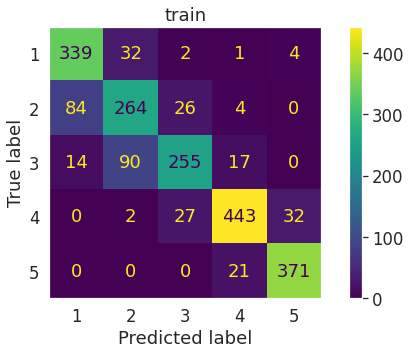

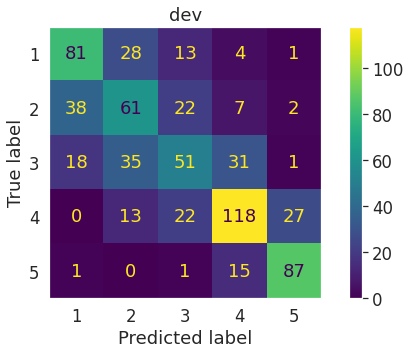

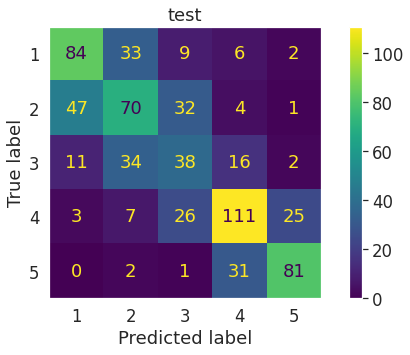

,Split,Accuracy
0,train,0.824458
1,dev,0.587888
2,test,0.568047


In [81]:
from sklearn.metrics import ConfusionMatrixDisplay
accuracy = []
for split in predictions:
  accuracy.append(predictions[split].metrics['test_accuracy'])
  ConfusionMatrixDisplay.from_predictions(predictions[split].label_ids+1, np.argmax(predictions[split].predictions, axis=1)+1)
  plt.title(split)
  plt.grid(False)
  plt.show()

df = pd.DataFrame({
    "Split" : list(predictions.keys()),
    "Accuracy" : accuracy
})  
display(HTML(df.to_html()))


Alough the accuracy is not perfect we can see from the confusion matrix that the model mistakes are mainly due to classifiying reviews a rating above or below their actual class.

In [92]:
load_from_file=True#@param {type:"boolean"}
if load_from_file:
  predict_df = pd.read_csv("results.csv")
else:
  all_labels = []
  all_predictions = []
  text = []
  splits = []
  for split in predictions:
    labels,predicted_class = predictions[split].label_ids+1, np.argmax(predictions[split].predictions, axis=1)+1
    for i, (label,prediction) in enumerate(zip(labels,predicted_class)):
        all_labels.append(label)
        all_predictions.append(prediction)
        splits.append(split)
        text.append(encoded_dataset[split][i]['text'])

  predict_df = pd.DataFrame({
      "label":all_labels,
      "prediction":all_predictions,
      "text":text,
      "split":splits
  })

In [106]:
#@title Lets take a look at where the model fails. { run: "auto" }
label = 1 #@param {type:"slider", min:1, max:5, step:1}
predict = 5 #@param {type:"slider", min:1, max:5, step:1}
df_select = predict_df[(predict_df["label"]==label) & (predict_df["prediction"]==predict)]
display(HTML(df_select.to_html()))

,label,prediction,text,split
363,1,5,great dress!! looks fab!,train
440,1,5,"I have bought Bali Flower Bras for years. They are the best for lifting and holding me still in my active lifestyle. I have tired many other styles, but always go back to this one. This bra is well made and holds up wash after wash after wash.",train
1597,1,5,I exchanged for a smaller size and now It's a perfect fit!,train
1842,1,5,I normally wear a 14/16 and ordered a size larger as per reading the reviews. They fit great! Waste is a bit big but i always wear a belt so its no big deal. I'm almost 6' and they are a good length for booties or to tuck in tall boots. Also will look cute with flats as the weather warms. Great dark color. Super comfortable with some stretch.,train
2412,1,5,I saw great reviews online for this and though it would be great because I was going to be an bridesmaid in my sister wedding.I went to Target and brought it.,dev
2726,1,5,This was so comfortable when I tried it on in the store that I bought several online.,test
3369,1,5,"I was obviously looking for something that would allow me to pump hands free and this is perfect! I am a size 34 D and I got the size medium! It fits perfectly, I have also washed and dried the bustier and it still fits perfectly! I will have to say the very first time I put it on I had a terrible time with the zipper, since the first initial wearing I had no further issues! I love this bustier!!! :)",test


If you take a look at the extrem prediction mismatches label 1 prediction 5 is easy to see why the model gets it wrong. Any human reading _"great dress!! looks fab!"_ or "_[...]Great dark color. Super comfortable with some stretch._" would though the reviewer really liked the product, to the point it is pausible to think that the reviewrs though 1 was the maximun rating or the rating is a mistake in the dataset.

The other end of the spectrum, label 5 prediction 1 stars with a praise but ends up with _"It ripped on the top part of the arm as the fabric couldnt withstand washing. This shirt is a waste of money unless you handwash and dry"_

This is a common pattern among the heavily missclasiffied reviews. 

The most common type of error comes when the model assign a similar label to a review (e.g. 3 instead of 4). Some mistakes could be corrected with more data or better training because they clearly reflect the true rating. However there are a vast group of reviews which could easily be interprepreated as different ratings than their true label. A possible solution could be adding a reviewer ID feature in order to exploit how each reviewer rating correlates with their way of writing 


# Final Summary

Deep learning models only get better with more data from the same distribution. A small dataset can yield good results with the use of a pretrained model but for better quality models more reviews could be added. Although reviews and ratings are correlated the exact rating is highly subjetive. There is no universal description for what makes a product a 3/5 instead of a 4/5. Because of this many reviews from the same class differ in tone. Adding something about the reviewer could guide the model predicting.

Another improvement could come in the cleaning of the data. Manual and extensive exploration of the dataset could allow us to find more problems. Also, not removing the puntuaction is an assumption I made but ideally models could be trained on data cleaned in different ways to find the best set of transformation to yield the best model